# License

    IPython notebook for running a trivial OpenCL program
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

import IPythonMagic

In [2]:
%setup_logging
%cuda_context_handler context

Python version 3.6.6 (default, Sep 12 2018, 18:26:19) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Registering context in user workspace
Creating context
PyCUDA version 2018.1.1
CUDA version (9, 1, 0)
Driver version 10000
Using 'Tesla K80' GPU
 => compute capability: (3, 7)
 => memory: 11188 / 11441 MB available
Created context handle <59101568>
Using CUDA cache dir /home/ubuntu/jupyter_notebooks/Andre Brodtkorb/MilanoGPU2018/notebooks/cuda_cache


In [3]:
cuda_kernel = """
__global__ void addKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addKernel")
kernel.prepare("PPP")

In [4]:
#Size of our test
n = 50

#Create test input / output data
a = np.random.rand(n).astype(np.float32)
b = np.random.rand(n).astype(np.float32)
c = np.empty_like(a)

#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

#Allocate output data
c_g = GPUArray(c.shape, np.float32)

#Execute program on device
grid = (n, 1, 1)
block = (1, 1, 1)
kernel.prepared_call(grid, block, c_g.gpudata, a_g.gpudata, b_g.gpudata)

#Copy data from device to host
c_g.get(c)

array([0.6408108 , 0.7748168 , 1.1302912 , 0.5175082 , 1.1517367 ,
       1.1635003 , 0.5460552 , 0.73032236, 1.4550138 , 0.6749335 ,
       1.6612455 , 1.6033114 , 0.41184846, 0.78726876, 0.38571256,
       0.87106377, 0.22370887, 0.02050326, 1.0771371 , 0.3470644 ,
       1.3131831 , 1.2191483 , 1.5626819 , 1.1103214 , 1.2173259 ,
       1.2895908 , 0.8962446 , 1.4471117 , 0.7200489 , 0.5924373 ,
       1.4236598 , 1.6060123 , 0.6484052 , 0.14840479, 1.252285  ,
       0.9147361 , 0.7727262 , 1.1435188 , 0.99868196, 1.1986296 ,
       0.5255389 , 0.74076825, 0.44471756, 0.64903855, 0.61401635,
       0.5393659 , 0.86570036, 1.6718545 , 0.22530302, 1.7938256 ],
      dtype=float32)

In [5]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [0.6408108  0.7748168  1.1302912  0.5175082  1.1517367  1.1635003
 0.5460552  0.73032236 1.4550138  0.6749335  1.6612455  1.6033114
 0.41184846 0.78726876 0.38571256 0.87106377 0.22370887 0.02050326
 1.0771371  0.3470644  1.3131831  1.2191483  1.5626819  1.1103214
 1.2173259  1.2895908  0.8962446  1.4471117  0.7200489  0.5924373
 1.4236598  1.6060123  0.6484052  0.14840479 1.252285   0.9147361
 0.7727262  1.1435188  0.99868196 1.1986296  0.5255389  0.74076825
 0.44471756 0.64903855 0.61401635 0.5393659  0.86570036 1.6718545
 0.22530302 1.7938256 ]
Ref =  [0.6408108  0.7748168  1.1302912  0.5175082  1.1517367  1.1635003
 0.5460552  0.73032236 1.4550138  0.6749335  1.6612455  1.6033114
 0.41184846 0.78726876 0.38571256 0.87106377 0.22370887 0.02050326
 1.0771371  0.3470644  1.3131831  1.2191483  1.5626819  1.1103214
 1.2173259  1.2895908  0.8962446  1.4471117  0.7200489  0.5924373
 1.4236598  1.6060123  0.6484052  0.14840479 1.252285   0.9147361
 0.7727262  1.1435188  0.99868196 1

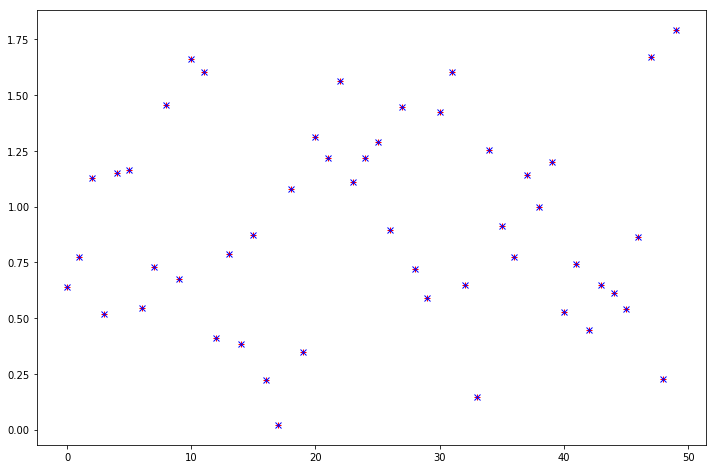

In [6]:
plt.figure(figsize=(12,8))
plt.plot(c, '+r')
plt.plot(c_ref, 'xb')

In [7]:
#free cuda context
context.detach()
context = None

Exception caught: Resetting to CUDA context context
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-fd3f931470e1>", line 2, in <module>
    context.detach()
AttributeError: 'CudaContext' object has no attribute 'detach'
Popping <59101568>
Pushing <59101568>


---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
~/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self, code_obj, result, async_)
   3264                 else:
-> 3265                     exec(code_obj, self.user_global_ns, self.user_ns)
   3266             finally:

<ipython-input-7-fd3f931470e1> in <module>
      1 #free cuda context
----> 2 context.detach()
      3 context = None

AttributeError: 'CudaContext' object has no attribute 'detach'

During handling of the above exception, another exception occurred:

NameError                                 Traceback (most recent call last)
~/jupyter_notebooks/Andre Brodtkorb/MilanoGPU2018/notebooks/IPythonMagic.py in custom_exc(shell, etype, evalue, tb, tb_offset)
     71 
     72             # still show the error within the notebook, don't just swallow it
---> 73             shell.showtraceback((etype

Custom TB Handler failed, unregistering
